c:\Users\19727\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score is 1.0
                       feature  importance
80           VP_Richard Cheney    0.789528
17           Name_GeorgeW Bush    0.789528
55               VP_Dan Quayle    0.526521
16          Name_GeorgeHW Bush    0.526521
75        VP_Lyndon B. Johnson    0.468310
28           Name_John Kennedy    0.468310
11           Name_Donald Trump    0.421505
77               VP_Mike Pence    0.421505
109  Population Percent Growth    0.243968
95            Party_Republican    0.220889
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        44
        True       1.00      1.00      1.00         4

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

'Model has been saved to 'sign_Gemini.pkl'


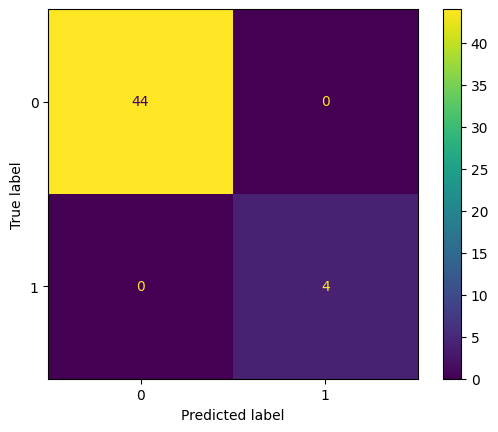

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

## IMPORT FILES TO TRANSFORM
pres_gdp = pd.read_csv("president_gdp-94.csv")
pres_terms = pd.read_csv("president_terms-94.csv",encoding="UTF-8") 

# input the testing feature to predict  
input = 'sign_Sagittarius'

## EXPAND YEAR OF TERMS PER LINE
# Create a new DataFrame that will contain the expanded rows
expanded_rows = []

# Iterate over each row and duplicate the data for each year between Start and Stop
for i, row in pres_terms.iterrows():
    for year in range(row['Start'], row['Stop']):
        row_data = row.to_dict()  # Convert row to a dictionary
        row_data['Year'] = year   # Add the expanded year to the dictionary
        expanded_rows.append(row_data)


#Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

## MERGE the two data frames on year
expanded_df = pd.merge(expanded_df,pres_gdp, on = "Year")

# Set index to 'Year' and select columns for categorical_df
categorical_df = expanded_df[['Year','Name', 'VP','BDay', 'Party','sign', 'BMonth', 'GDP Growth', 'Population Growth']].set_index('Year')

# Select numerical columns for numerical_df
numerical_df = expanded_df[['Year','GDP Percent Growth', 'Population Percent Growth']].set_index('Year')

# Dummify (one-hot encode) The categoricals
categorical_df = pd.get_dummies(categorical_df)

# Merge categorical and numerical dataframes
dummy_df = pd.merge(categorical_df,numerical_df, left_index=True, right_index=True)

# Exclude the columns in y from dummy_df3
y = dummy_df[[input]]

# Define the target columns (y)
X = dummy_df.loc[:, ~dummy_df.columns.isin(y.columns)]

# Split the preprocessed data into a training and testing dataset -- choose to stratify so that the classes are more balanced out bc it's a small dataset and imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler on the training data
X_scaler = scaler.fit(X_train)

# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Initialize a multi-output classifier with logistic regression
classifier = LogisticRegression()

# Fit the logistic regression model on the training data
classifier.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_scaled)

## Create accuracy score
accuracy_score(y_true= y_test, y_pred= y_pred)
print(f"Accuracy score is {accuracy_score(y_true= y_test, y_pred= y_pred)}")

## Create Confusion Matrix 
cm_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred))
disp.plot()

## Display which features are most important 
# Get the absolute values of the coefficients
abs_importances = abs(classifier.coef_[0])  # Get the coefficients from the trained Logistic Regression model

# Create a DataFrame with feature names and their corresponding importances
df_importance = pd.DataFrame({
    'feature': X_train.columns,  # assuming X_train is a DataFrame
    'importance': abs_importances  # use absolute value of coefficients
})

# Sort the DataFrame by importance (descending order)
df_importance = df_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features (absolute importance)
print(df_importance.head(10))

# Print the classification report for the model
print(classification_report(y_true = y_test, y_pred = y_pred))

# Save the trained model directly using joblib
joblib.dump(classifier, '{input}.pkl')
print(f"'Model has been saved to '{input}.pkl'")